<a href="https://colab.research.google.com/github/imtiaz114/Brain_tumor_detection_from_2D_MRI_images/blob/main/Brain_tumor_detection_transfer_learning_dataset2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Transfer Learning

## imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob, os, shutil,random
import tensorflow as tf
import cv2


from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data Preprocessing

80_20 train_test_split

batch size 16 gives best result

In [3]:
BATCH_SIZE = 16
IMG_SIZE = (224,224)

train_dir = '/content/drive/MyDrive/Dataset_2/final_dataset/Dataset2/80_20/train/'
test_dir  = '/content/drive/MyDrive/Dataset_2/final_dataset/Dataset2/80_20/test/'

### Dataset_creation

In [4]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2612 files belonging to 2 classes.


In [5]:
test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 653 files belonging to 2 classes.


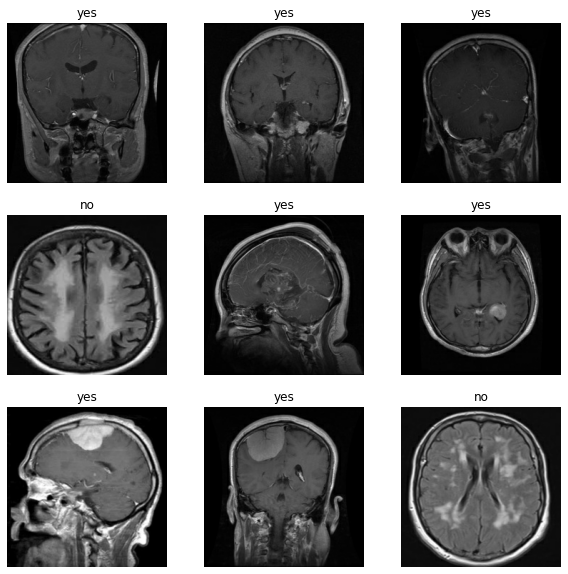

In [6]:
#Show the first nine images and labels from the training set:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Configuring the dataset performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

### rescale pixel values

In [9]:
preprocess_input =  tf.keras.applications.vgg16.preprocess_input

## Create the base model from the pre-trained convnets

In [10]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.efficientnet import EfficientNetB7 as tl_model

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tl_model(weights= 'imagenet', input_tensor= Input(shape = IMG_SHAPE), include_top= False)

258080768/258076736 [==============================] - 2s 0us/step


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 2560)


## Feature extraction

### Freeze the convolutional base

In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

### Add a classification head

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2560)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [16]:
inputs = tf.keras.Input(shape=(224,224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [17]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      #tf.keras.metrics.Precision(name='precision'),
      #tf.keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
      #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [18]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2560)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0     

In [20]:
len(model.trainable_variables)

2

### Train the model

In [21]:
initial_epochs = 250

loss0, accuracy0 = model.evaluate(train_dataset)

164/164 [==============================] - 386s 2s/step - loss: 0.7083 - accuracy: 0.1191


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.12


In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    callbacks=[early_stopping])

Epoch 1/250
164/164 [==============================] - 47s 197ms/step - loss: 0.2689 - accuracy: 0.8855
Epoch 2/250
164/164 [==============================] - 33s 201ms/step - loss: 0.1827 - accuracy: 0.9292
Epoch 3/250
164/164 [==============================] - 33s 203ms/step - loss: 0.1623 - accuracy: 0.9403
Epoch 4/250
164/164 [==============================] - 34s 204ms/step - loss: 0.1491 - accuracy: 0.9430
Epoch 5/250
164/164 [==============================] - 34s 206ms/step - loss: 0.1387 - accuracy: 0.9468
Epoch 6/250
164/164 [==============================] - 35s 209ms/step - loss: 0.1351 - accuracy: 0.9472
Epoch 7/250
164/164 [==============================] - 34s 209ms/step - loss: 0.1285 - accuracy: 0.9506
Epoch 8/250
164/164 [==============================] - 34s 209ms/step - loss: 0.1234 - accuracy: 0.9498
Epoch 9/250
164/164 [==============================] - 34s 209ms/step - loss: 0.1208 - accuracy: 0.9525
Epoch 10/250
164/164 [==============================] - 35s 209m

### Learning Curves

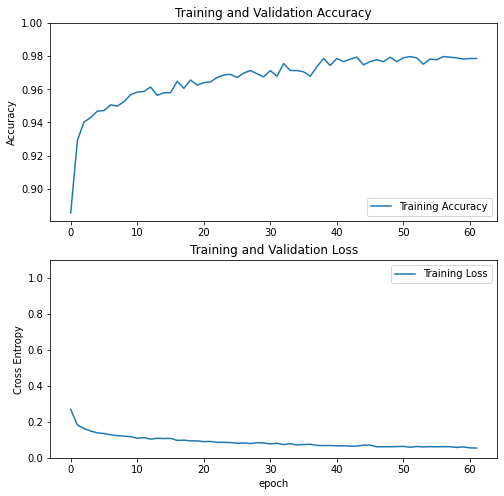

In [25]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

### Un-freeze the top layers of the model


In [26]:
base_model.trainable = True

In [27]:
print("Number of layers in the base model: ", len(base_model.layers))

## Fine-tune from this layer onwards
#fine_tune_at = 100

## Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:fine_tune_at]:
#  layer.trainable =  False

Number of layers in the base model:  813


### compiling the model

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=METRICS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 7, 7, 2560)        64097687  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2560)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0     

In [30]:
len(model.trainable_variables)

711

### continue training the model

In [31]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=[early_stopping])

Epoch 62/350
164/164 [==============================] - 218s 1s/step - loss: 0.2914 - accuracy: 0.9554
Epoch 63/350
164/164 [==============================] - 172s 1s/step - loss: 0.0561 - accuracy: 0.9843
Epoch 64/350
164/164 [==============================] - 170s 1s/step - loss: 0.0321 - accuracy: 0.9900
Epoch 65/350
164/164 [==============================] - 169s 1s/step - loss: 0.0348 - accuracy: 0.9946
Epoch 66/350
164/164 [==============================] - 169s 1s/step - loss: 0.0432 - accuracy: 0.9935
Epoch 67/350
164/164 [==============================] - 169s 1s/step - loss: 0.0179 - accuracy: 0.9962
Epoch 68/350
164/164 [==============================] - 170s 1s/step - loss: 0.0289 - accuracy: 0.9943
Epoch 69/350
164/164 [==============================] - 169s 1s/step - loss: 0.0130 - accuracy: 0.9973
Epoch 70/350
164/164 [==============================] - 169s 1s/step - loss: 0.0222 - accuracy: 0.9969
Epoch 71/350
164/164 [==============================] - 168s 1s/step - lo

In [32]:
# Save the weights
model.save_weights('/content/drive/MyDrive/Dataset_2/final_dataset/weights/transfer_learning_dataset2')

In [33]:
acc += history_fine.history['accuracy']

loss += history_fine.history['loss']

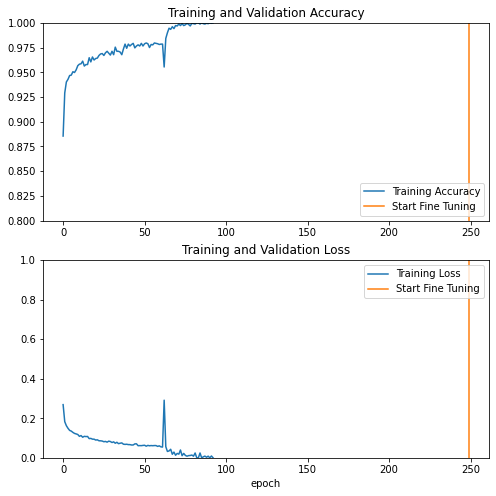

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and Prediction

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

41/41 [==============================] - 117s 2s/step - loss: 0.0971 - accuracy: 0.9954
Test accuracy : 0.9954057931900024


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
Labels:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]


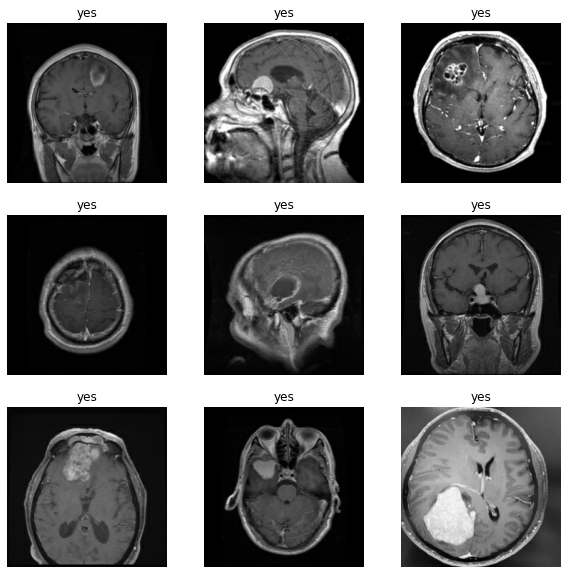

In [36]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")